# LOADING PACKAGES

In [1]:
# analysis
import pandas as pd
import numpy as np
from scipy import stats

# visualization
import matplotlib.pyplot as plt
import seaborn as sns


# preprocessingn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# metrics
from sklearn.metrics import mean_squared_error, make_scorer


# model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate, cross_val_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, RepeatedKFold, KFold
import optuna

# classification
from lightgbm import LGBMClassifier

# regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
# from sklearn.en

import warnings

warnings.filterwarnings('ignore')

# Dataset Overview

In [39]:
# loading datasets
train = pd.read_csv("/kaggle/input/playground-series-s3e9/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e9/test.csv")
sub = pd.read_csv("/kaggle/input/playground-series-s3e9/sample_submission.csv")
original = pd.read_csv("/kaggle/input/predict-concrete-strength/ConcreteStrengthData.csv")

train.head()

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19


In [40]:
original.columns = [x.strip() for x in original.columns]
original = original[train.drop(columns=['id']).columns]

In [41]:
# overall shapes
print(f"Training set has {train.shape[0]} rows and {train.shape[1]} cols")
print(f"Test set has {test.shape[0]} rows and {test.shape[1]} cols")
print(f"original set has {original.shape[0]} rows and {original.shape[1]} cols")

Training set has 5407 rows and 10 cols
Test set has 3605 rows and 9 cols
original set has 1030 rows and 9 cols


In [42]:
# number of nulls in train and test set
null_train = train.isnull().sum().sum()
null_test = test.isnull().sum().sum()
null_original = original.isnull().sum().sum()

print(f"Number of nulls in train: {null_train}")
print(f"Number of nulls in test: {null_test}")
print(f"Number of nulls in original: {null_original}")

Number of nulls in train: 0
Number of nulls in test: 0
Number of nulls in original: 0


In [43]:
train_dtypes = train.dtypes.value_counts()
test_dtypes = test.dtypes.value_counts()
original_dtypes = original.dtypes.value_counts()

print("Training dataset: ", end='\n\n')
display(train_dtypes)
print("Test dataset: ", end='\n\n')
display(test_dtypes)
print('Original dataset: ', end='\n\n')
display(original_dtypes)
print('Bookings dataset: ', end='\n\n')
display(original_dtypes)

Training dataset: 



float64    8
int64      2
dtype: int64

Test dataset: 



float64    7
int64      2
dtype: int64

Original dataset: 



float64    8
int64      1
dtype: int64

Bookings dataset: 



float64    8
int64      1
dtype: int64

In [44]:
train_dup = train.drop(['Strength', 'id'], axis=1).duplicated().sum()
test_dup = test.drop("id", axis=1).duplicated().sum()
original_dup = original.drop("Strength", axis=1).duplicated().sum()


print(f"duplicates in train :{train_dup},  test :{test_dup} and original: {original_dup}")

duplicates in train :2401,  test :1351 and original: 38


****Insights:****
 * The dataset is very small and ther are 8 independent features where 7 where continous feature and one is discrete feature. There is not categorical feature present.  
 * There are too many duplicates in train set and test set. Compared to them they are very less in orignal. 
 * We can just delete duplicates from original but we need to dig a little more for train and test

In [45]:
# dropping duplicates in original
original = original[~original.drop("Strength", axis=1).duplicated(keep=False)]

----researching duplicates----

In [46]:
cols = list(train.drop(columns=['id', 'Strength']).columns)

In [47]:
train_dup = train[train.drop(['Strength', 'id'], axis=1).duplicated(keep=False)].sort_values(by=cols)
test_dup = test[test.drop(['id'], axis=1).duplicated(keep=False)].sort_values(by=cols)
train_dup.head()

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
1036,1036,102.0,153.0,0.0,192.0,0.0,887.0,942.0,7,26.26
1669,1669,102.0,153.0,0.0,192.0,0.0,887.0,942.0,7,14.59
4607,4607,102.0,153.0,0.0,192.0,0.0,887.0,942.0,7,20.97
5193,5193,102.0,153.0,0.0,192.0,0.0,887.0,942.0,7,16.88
310,310,102.0,153.0,0.0,192.0,0.0,887.0,942.0,28,20.87


In [48]:
# s.drop('id', axis=1).groupby(cols).filter(lambda x: np.nan_to_num(x['Strength'].std()) < 6)

In [49]:
dup_cnts_train = train_dup.groupby(cols)['id'].size().reset_index().rename(columns={'id': 'Count'})
dup_cnts_test = test_dup.groupby(cols)['id'].size().reset_index().rename(columns={'id': 'Count'})

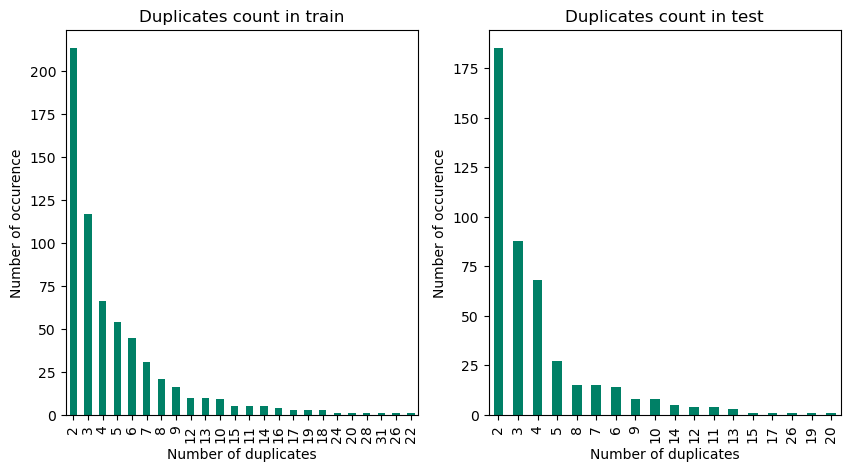

In [50]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
dup_cnts_train['Count'].value_counts().plot(kind='bar', cmap='summer')
plt.title("Duplicates count in train")
plt.xlabel("Number of duplicates")
plt.ylabel("Number of occurence")

plt.subplot(1, 2, 2)
dup_cnts_test['Count'].value_counts().plot(kind='bar', cmap='summer')
plt.title("Duplicates count in test")
plt.xlabel("Number of duplicates")
plt.ylabel("Number of occurence");

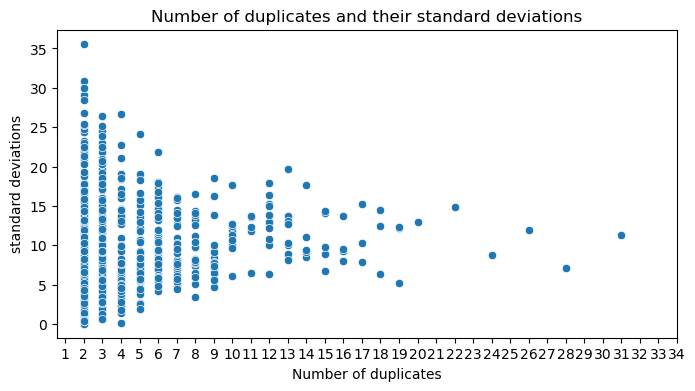

In [51]:
dup_info = train_dup.groupby(cols)['Strength'].agg(['count', 'std']).reset_index()

plt.figure(figsize=(8, 4))
sns.scatterplot(data=dup_info, x='count', y='std')
plt.xticks(ticks=range(1, 35))
plt.xlabel('Number of duplicates')
plt.ylabel("standard deviations")
plt.title("Number of duplicates and their standard deviations");

We can see that we have a lot of duplicates of the same observation and in when number of duplicates are small some have very large standard deviations. So what we can do is we can remove duplicates which has high standard deviations(possible solution need check with leader board score)

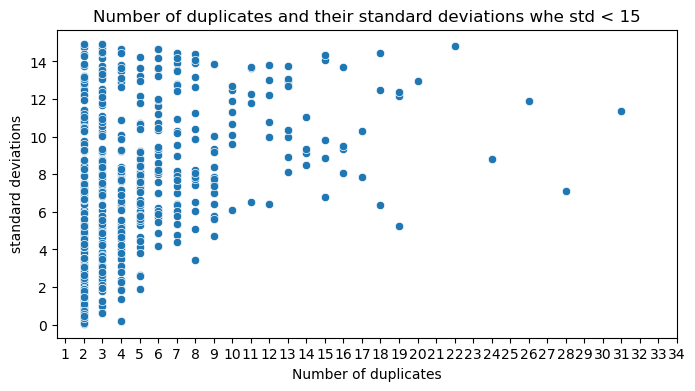

In [52]:
train_dup2 = train_dup.drop('id', axis=1).groupby(cols).filter(lambda x: np.nan_to_num(x['Strength'].std()) < 15)
dup_info = train_dup2.groupby(cols)['Strength'].agg(['count', 'std']).reset_index()


plt.figure(figsize=(8, 4))
sns.scatterplot(data=dup_info, x='count', y='std')
plt.xticks(ticks=range(1, 35))
plt.xlabel('Number of duplicates')
plt.ylabel("standard deviations")
plt.title("Number of duplicates and their standard deviations whe std < 15");

In [53]:
t = train_dup.drop('id', axis=1).groupby(cols).filter(lambda x: np.nan_to_num(x['Strength'].std()) < 10)
z = test.merge(t.drop('Strength', axis=1), on=cols, how='inner', indicator=True)
z['_merge'].value_counts()

both          6447
left_only        0
right_only       0
Name: _merge, dtype: int64

In [54]:
# z.sort_values(ascending=False)

In [55]:
# merged

----end----


# EDA

In [57]:
feats = train.drop(['id', 'Strength'], axis=1).columns

In [62]:
train = train[train['AgeInDays'] != 49]

****Correlation****

We will use spearman correlation which can detect non linear relationship

In [85]:
train_corr = train.copy()

cols_to_sum = train_corr.drop(columns=['id', 'AgeInDays', 'Strength']).columns.tolist()
train_corr['Water/Cement'] = train_corr['WaterComponent'] / train_corr['CementComponent']
train_corr['Blast+Cement+FlyAsh'] = train_corr['BlastFurnaceSlag'] + train_corr['CementComponent'] + train_corr['FlyAshComponent']
train_corr['Blast+Cement+FlyAsh/Water'] =  train_corr['WaterComponent']/train_corr['Blast+Cement+FlyAsh']
train_corr['Fine+Coarse'] = train_corr['FineAggregateComponent'] + train_corr['CoarseAggregateComponent']
train_corr['Fine+Coarse/Cement'] = train_corr['Fine+Coarse'] / train_corr['CementComponent']
train_corr['Fine+Coarse/Blast+Cement+FlyAsh'] = train_corr['Fine+Coarse'] / train_corr['Blast+Cement+FlyAsh']
train_corr['Age*Blast+Cement+FlyAsh'] = train_corr['AgeInDays'] * train_corr['Blast+Cement+FlyAsh'] 
train_corr['TotalWeight'] = train_corr[cols_to_sum].sum(axis=1)

train_corr['obs_std'] = train_corr.std(axis=1)
train_corr['obs_mean'] = train_corr.mean(axis=1)
train_corr['obs_median'] = train_corr.median(axis=1)


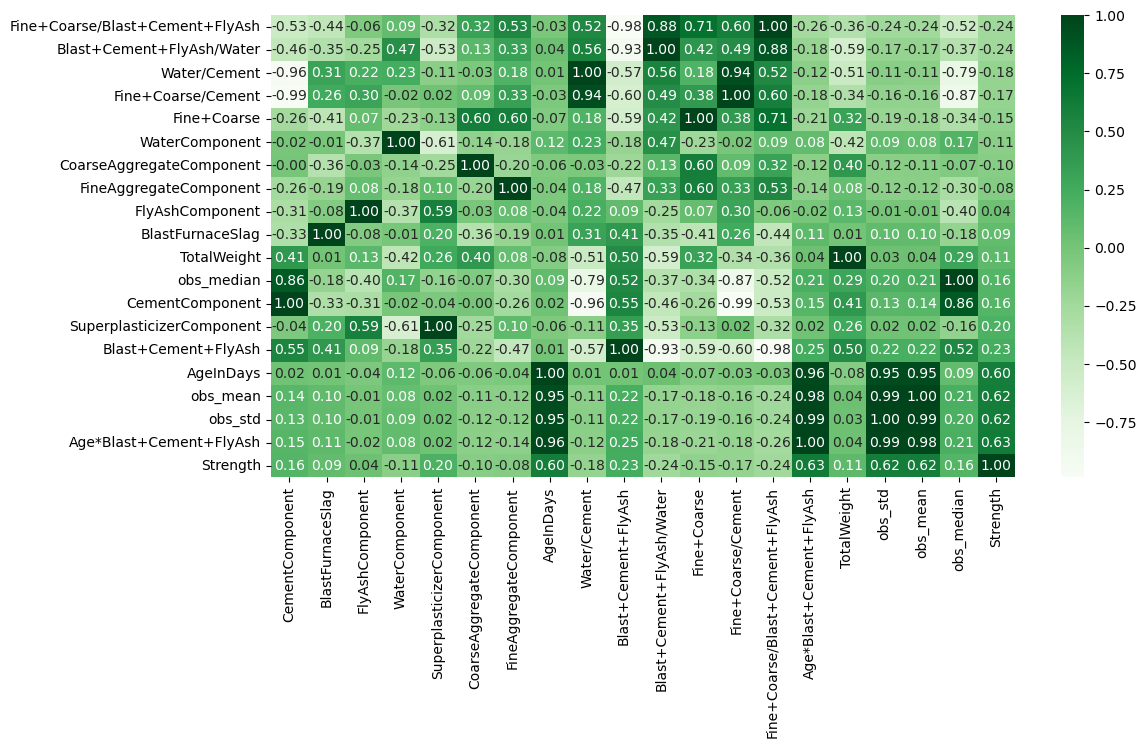

In [86]:
plt.figure(figsize=(12, 6))
corr = train_corr.drop('id', axis=1).corr('spearman').sort_values('Strength')
corr = corr[corr.drop('Strength', axis=1).columns.tolist() + ['Strength']]

# mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Greens')
plt.show()

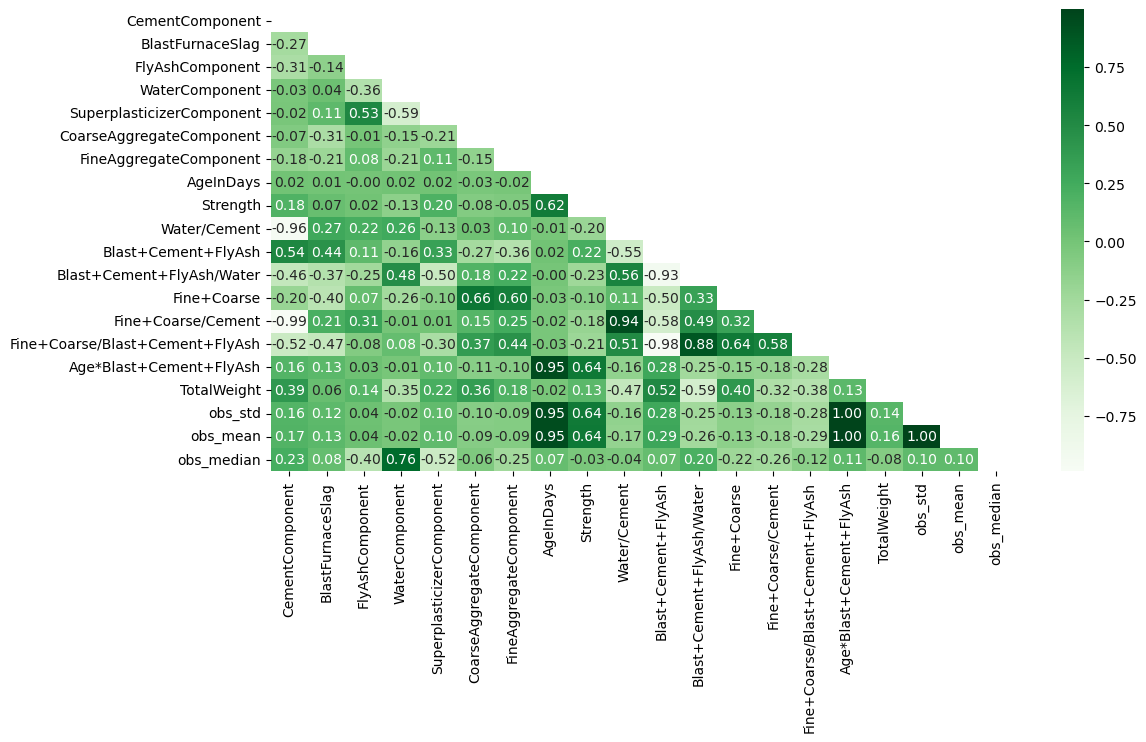

In [100]:
train_agg = train.groupby(cols)['Strength'].median().reset_index()
train_corr = train_agg.copy()

cols_to_sum = train_corr.drop(columns=['AgeInDays', 'Strength']).columns.tolist()
train_corr['Water/Cement'] = train_corr['WaterComponent'] / train_corr['CementComponent']
train_corr['Blast+Cement+FlyAsh'] = train_corr['BlastFurnaceSlag'] + train_corr['CementComponent'] + train_corr['FlyAshComponent']
train_corr['Blast+Cement+FlyAsh/Water'] =  train_corr['WaterComponent']/train_corr['Blast+Cement+FlyAsh']
train_corr['Fine+Coarse'] = train_corr['FineAggregateComponent'] + train_corr['CoarseAggregateComponent']
train_corr['Fine+Coarse/Cement'] = train_corr['Fine+Coarse'] / train_corr['CementComponent']
train_corr['Fine+Coarse/Blast+Cement+FlyAsh'] = train_corr['Fine+Coarse'] / train_corr['Blast+Cement+FlyAsh']
train_corr['Age*Blast+Cement+FlyAsh'] = train_corr['AgeInDays'] * train_corr['Blast+Cement+FlyAsh'] 
train_corr['TotalWeight'] = train_corr[cols_to_sum].sum(axis=1)

train_corr['obs_std'] = train_corr.std(axis=1)
train_corr['obs_mean'] = train_corr.mean(axis=1)
train_corr['obs_median'] = train_corr.median(axis=1)


plt.figure(figsize=(12, 6))
corr = train_corr.corr('spearman')
# corr = corr[corr.drop('Strength', axis=1).columns.tolist() + ['Strength']]

mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Greens', mask=mask)
# sns.heatmap(corr, annot=True, fmt='.2f', cmap='YlOrRd', mask=mask)
plt.show()

# PREPROCESSING


In [101]:
def process_fit_transform(X_, y, scaler_method, _feats):
    X_ = X_.copy()
     # Preprocessing for numerical data
    scaler_x = scaler_method
    X_[_feats] = scaler_x.fit_transform(X_[_feats])
    
    scaler_y = StandardScaler()
    y = scaler_y.fit_transform(y.to_frame())
    
    return X_, y, scaler_x, scaler_y


def process_transform(X_test, scaler_x, _feats):
    X_test_ = X_test.copy()
    X_test_[_feats] = scaler_x.transform(X_test_[_feats])

    return X_test_

# custom loss metric for cv and also making it the same as leaderboard
def root_mean_squared_error(y_true, y_pred, **kwargs):
    y_true = scaler_y.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    return np.sqrt(mean_squared_error(y_true, y_pred))
my_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

def repeated_cross_val_score(model, _X, _y, n_repeats=3, n_splits=5):
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
    history = cross_validate(model, _X, _y, scoring=my_scorer, return_train_score=True, n_jobs=-1, cv=cv)
    return -(history['train_score']).mean(), -(history['test_score']).mean()


def scale_y(model_preds, scaler):
    return scaler.inverse_transform(model_preds.reshape(-1, 1)).flatten()


def make_predictions(model, _X, _y, X_test_, threshold=12, n_repeats=3, n_splits=5):
    skfold = RepeatedKFold(n_repeats=n_repeats, n_splits=n_splits, random_state=10)
    _y = pd.Series(_y.flatten())
    _model = model

    test_preds = []
    valid_scores = []
    train_scores = []
    for i, (train_index, valid_index) in enumerate(skfold.split(_X, _y)):
        x_train, x_valid = _X.iloc[train_index], _X.iloc[valid_index]
        y_train, y_valid = _y.iloc[train_index], _y.iloc[valid_index]

        _model.fit(x_train, y_train)
        
        val_preds = _model.predict(x_valid)
        val_score = root_mean_squared_error(y_valid.values, val_preds)
        
        if val_score < threshold:
#             print(f"Fold {i} validation score : {val_score}")
            _model_train_preds = _model.predict(x_train)
            _model_valid_preds = _model.predict(x_valid)
            _model_test_preds = scale_y(_model.predict(X_test_), scaler_y)

            _model_train_score = root_mean_squared_error(y_train.values, _model_train_preds)
            _model_valid_score = root_mean_squared_error(y_valid.values, val_preds)
            
        
            train_scores.append(_model_train_score)
            valid_scores.append(_model_valid_score)
            test_preds.append(_model_test_preds)
    
    print(f"Used {len(valid_scores)} folds to train model")
    print(f"Highest Loss in train: {np.max(train_scores)} and valid: {np.max(valid_scores)}")
    test_preds = np.array(test_preds)
    test_preds_final = test_preds.mean(axis=0) 
    mean_train_score = np.mean(train_scores)
    mean_valid_score = np.mean(valid_scores)
    

    return test_preds_final, mean_train_score, mean_valid_score

def make_simple_predictions(model, _X, _y, X_test_):
    _model = model
    model.fit(_X, _y)
    y_preds = scale_y(model.predict(X_test_), scaler_y)
    return y_preds


def create_features(train_df):
    train_corr = train_df.copy()
    train_corr['Blast+Cement+FlyAsh'] = train_corr['BlastFurnaceSlag'] + train_corr['CementComponent'] + train_corr['FlyAshComponent']
    train_corr['Fine+Coarse'] = train_corr['FineAggregateComponent'] + train_corr['CoarseAggregateComponent']
    train_corr['Fine+Coarse/Cement'] = train_corr['Fine+Coarse'] / train_corr['CementComponent']
    train_corr['Fine+Coarse/Blast+Cement+FlyAsh'] = train_corr['Fine+Coarse'] / train_corr['Blast+Cement+FlyAsh']
    train_corr['Age*Blast+Cement+FlyAsh'] = train_corr['AgeInDays'] * train_corr['Blast+Cement+FlyAsh'] 
    train_corr['TotalWeight'] = train_corr[cols_to_sum].sum(axis=1)
#     
#     train_corr.drop(columns=["Fine+Coarse"], axis=1, inplace=True)


    return train_corr

In [137]:

# _train_score, _valid_score = repeated_cross_val_score(GradientBoostingRegressor(), X, y.flatten())
# print(X_new.shape)

# # dropped water/cement, std, mean, sum, blash+cement+flyash/water
# print(f"train_score {_train_score} and valid_score {_valid_score}")

(5406, 14)
train_score 11.46857598643451 and valid_score 12.147739312639734


In [136]:
# train_new = create_features(train)
# feats_new = train_new.drop(['id', 'Strength'], axis=1).columns.tolist()
# X_new, y_new = train_new.drop(['id', 'Strength'], axis=1), train_new['Strength']

# X_new, y_new, scaler_x_new, scaler_y = process_fit_transform(X_new, y_new, RobustScaler(), feats_new)

# _train_score, _valid_score = repeated_cross_val_score(GradientBoostingRegressor(), X_new, y_new.flatten())
# print(X_new.shape)

# # dropped water/cement, std, mean, sum, blash+cement+flyash/water
# print(f"train_score {_train_score} and valid_score {_valid_score}")

(5406, 14)
train_score 11.344493499987571 and valid_score 12.149462848004427


In [88]:
# train_new = create_features(train)
# feats_new = train_new.drop(['id', 'Strength'], axis=1).columns.tolist()
# X_new, y_new = train_new.drop(['id', 'Strength'], axis=1), train_new['Strength']

# X_new, y_new, scaler_x_new, scaler_y = process_fit_transform(X_new, y_new, RobustScaler(), feats_new)

# _train_score, _valid_score = repeated_cross_val_score(GradientBoostingRegressor(), X_new, y_new.flatten())
# print(X_new.shape)

# # dropped water/cement, std, mean, sum, blash+cement+flyash/water
# print(f"train_score {_train_score} and valid_score {_valid_score}")

(5406, 14)
train_score 11.344493499987571 and valid_score 12.14970034824302


In [84]:
# train_new = create_features(train)
# feats_new = train_new.drop(['id', 'Strength'], axis=1).columns.tolist()
# X_new, y_new = train_new.drop(['id', 'Strength'], axis=1), train_new['Strength']

# X_new, y_new, scaler_x_new, scaler_y = process_fit_transform(X_new, y_new, RobustScaler(), feats_new)

# _train_score, _valid_score = repeated_cross_val_score(GradientBoostingRegressor(), X_new, y_new.flatten())
# print(X_new.shape)

# # dropped water/cement, std, mean, sum, blast+cement+flyash, blast+cement+flyash/water 
# print(f"train_score {_train_score} and valid_score {_valid_score}")

(5406, 13)
train_score 11.342239327808153 and valid_score 12.153053830552846


In [65]:
# train_new = create_features(train)
# feats_new = train_new.drop(['id', 'Strength'], axis=1).columns.tolist()
# X_new, y_new = train_new.drop(['id', 'Strength'], axis=1), train_new['Strength']

# X_new, y_new, scaler_x_new, scaler_y = process_fit_transform(X_new, y_new, RobustScaler(), feats_new)

# _train_score, _valid_score = repeated_cross_val_score(GradientBoostingRegressor(), X_new, y_new.flatten())
# print(X_new.shape)

# # dropped water/cement, std, mean, sum, blash+cement+flyash
# print(f"train_score {_train_score} and valid_score {_valid_score}")

(5406, 14)
train_score 11.340687153978244 and valid_score 12.155554000204914


In [56]:
# train_new = create_features(train)
# feats_new = train_new.drop(['id', 'Strength'], axis=1).columns.tolist()
# X_new, y_new = train_new.drop(['id', 'Strength'], axis=1), train_new['Strength']

# X_new, y_new, scaler_x_new, scaler_y = process_fit_transform(X_new, y_new, RobustScaler(), feats_new)

# _train_score, _valid_score = repeated_cross_val_score(GradientBoostingRegressor(), X_new, y_new.flatten())
# print(X_new.shape)

# # dropped water/cement, std, mean, sum
# print(f"train_score {_train_score} and valid_score {_valid_score}")

(5406, 15)
train_score 11.345841185500507 and valid_score 12.16373318530406


In [131]:
def scaler_y_valid(_y, scaler):
    return scaler.inverse_transform(_y.reshape(-1, 1)).flatten()


train_train, train_valid = train_test_split(train, test_size=0.13)
train_x_valid, train_y_valid = train_valid.drop(["Strength", 'id'], axis=1), train_valid['Strength']

train_agg = train_train.groupby(cols)['Strength'].median().reset_index()
train_agg.shape

(2675, 9)

In [132]:
train_x_valid.shape, train_y_valid.shape

((703, 8), (703,))

In [133]:
feats = train.drop(['id', 'Strength'], axis=1).columns.tolist()
X, y = train.drop(['id', 'Strength'], axis=1), train['Strength']

X, y, scaler_x, scaler_y = process_fit_transform(X, y, RobustScaler(), feats)
# X_test = process_transform(test.drop('id', axis=1), scaler_x, feats)

X2, y2 = train_agg.drop(['Strength'], axis=1), train_agg['Strength']
X2, y2, scaler_x2, scaler_y2 = process_fit_transform(X2, y2, RobustScaler(), feats)
train__x_valid = process_transform(train_x_valid, scaler_x2, feats)


# train_new = create_features(train)
# feats_new = train_new.drop(['id', 'Strength'], axis=1).columns.tolist()
# X_new, y_new = train_new.drop(['id', 'Strength'], axis=1), train_new['Strength']

# X_new, y_new, scaler_x_new, scaler_y = process_fit_transform(X_new, y_new, RobustScaler(), feats_new)

In [144]:
X_test_new = create_features(test)
X_test_new = process_transform(X_test_new.drop('id', axis=1), scaler_x_new, feats_new)

In [ ]:
# train.drop(['id'], axis=1).groupby(cols).filter(lambda x: np.nan_to_num(x['Strength'].std()) < 15).shape

In [ ]:
# def make_predictions_test(model, _X, _y, _test, threshold=12, n_repeats=3, n_splits=5):
#     skfold = RepeatedKFold(n_repeats=n_repeats, n_splits=n_splits)
#     _model = model
    
#     _test = _test.drop("id", axis=1)
    
#     test_preds = []
#     valid_scores = []
#     train_scores = []
    
#     for i, (train_index, valid_index) in enumerate(skfold.split(_X, _y)):
        
#         x_train, x_valid = _X.iloc[train_index], _X.iloc[valid_index]
#         y_train, y_valid = _y.iloc[train_index], _y.iloc[valid_index]
         
#         x_train, y_train, scaler_x, scaler_y = process_fit_transform(x_train, y_train, RobustScaler(), feats)
#         x_valid = process_transform(x_valid, scaler_x, feats)
#         y_valid = scale_y(y_valid, scaler_y)
    
#         _model.fit(x_train, y_train)
        
#         val_preds = _model.predict(x_valid)
#         val_score = root_mean_squared_error(y_valid, val_preds)
        
#         if val_score < threshold:
#             print(f"Fold {i} validation score : {val_score}")
            
#             X_test = process_transform(_test, scaler_x, feats) 
#             _model_train_preds = _model.predict(x_train)
#             _model_valid_preds = _model.predict(x_valid)
#             _model_test_preds = inverse_scale_y(_model.predict(X_test), scaler_y)
            
#             _model_train_score = root_mean_squared_error(y_train, _model_train_preds)
#             _model_valid_score = root_mean_squared_error(y_valid, val_preds)
            
        
#             train_scores.append(_model_train_score)
#             valid_scores.append(_model_valid_score)
#             test_preds.append(_model_test_preds)
    
#     print(len(test_preds))
    
#     test_preds = np.array(test_preds)
#     test_preds_final = test_preds.mean(axis=0) 
#     mean_train_score = np.mean(train_scores)
#     mean_valid_score = np.mean(valid_scores)
    

#     return test_preds_final, mean_train_score, mean_valid_score

# Model Building

## Baseline Score

In [144]:
def dump_model(models_log, model_name, description, model_params, train_score, valid_score, sub_cv, lead_score):
    info = {'Model name': model_name, 'Description': description, 'Model params': model_params, 'Local cv train score': train_score,
               "Local cv valid score": valid_score, "Trained using cv": sub_cv, "Leaderboard score": lead_score}
            
    models_log = models_log.append(info, ignore_index=True)
    
    return models_log


def submission_csv(predictions):
    df = pd.DataFrame()
    df['id'] = test['id']
    df['Strength'] = predictions
    
    return df


models_log = pd.DataFrame(columns=['Model name', "Description", 'Model params', 'Local cv train score', "Local cv valid score", 
                               "Trained using cv", 'Leaderboard score'])
# models_log.set_index('Model name', inplace=True)

****Trying out different models****

In [105]:
import gc
from xgboost import XGBRegressor

****Submission with defualt LinearRegression(with and without crossval)****

In [145]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(random_state=0),
    "Lasso": Lasso(random_state=0),
#     "ElasticNet": ElasticNet(random_state=0),
#     "RandomForestRegressor": RandomForestRegressor(random_state=0),
#     "AdaBoostRegressor": AdaBoostRegressor(random_state=0), 
#     "GradientBoostRegressor": GradientBoostingRegressor(random_state=0),
#     "HistGradientBoostingRegressor":  HistGradientBoostingRegressor(random_state=0),
#     "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
#     "CatBoostRegressor": CatBoostRegressor(random_state=0, verbose=False),
#     "LGBMRegressor": LGBMRegressor(random_state=0),
#     "XGBRegressor": XGBRegressor(random_state=0),
#     "KNeighborsRegressor": KNeighborsRegressor(),
#     "SVR": SVR(),
}



# default_scores = pd.DataFrame({
#     "Model names": models.keys(), "Train score": np.zeros(len(models)), "Valid score": np.zeros(len(models))
# })

# default_scores.set_index("Model names", inplace=True)
for mod_name, model in models.items():
    print(f"Training using {mod_name}")
    _train_score, _valid_score = repeated_cross_val_score(model, X, y.flatten())

#     default_scores.loc[mod_name] = [_train_score, _valid_score]
    description = f"Using default {mod_name} and making predictions on valid using crossvalcv"
    models_log = dump_model(models_log, mod_name, description, np.nan, _train_score, _valid_score, True, True)
    
    
    mod = model
    mod.fit(X2, y2)
    
    preds = scaler_y_valid(mod.predict(train_x_valid), scaler_y2)
    _valid_score = np.sqrt(mean_squared_error(train_y_valid, preds))
    description = f"Using default {mod_name} with new features added and making predictions on valid set using crossvalcv"
    models_log = dump_model(models_log, mod_name, description, np.nan, -1, _valid_score, True, False)
#     _train_score, _valid_score = repeated_cross_val_score(model, X_new, y_new.flatten())
#     description = f"Using default {mod_name} with new features added and making predictions on valid set using crossvalcv"
#     models_log = dump_model(models_log, mod_name, description, np.nan, _train_score, _valid_score, True, True)
    
    del _train_score, _valid_score
    gc.collect()

Training using Linear Regression
Training using Ridge
Training using Lasso


In [ ]:
pd.set_option('display.float_format', lambda x: "%.5f" % x)

In [157]:
model = HistGradientBoostingRegressor(random_state=0, verbose=False)
mod_name = "Hist"



print("#"*10,"GradientBoostingRegressor crossval", "#"*10)
cv_preds, _train_score, _valid_score = make_predictions(model, X, y, X_test, threshold=12.18)
print("Mean valid score during submission: ", _valid_score)
cv_df = submission_csv(cv_preds)
cv_df.to_csv(f"{mod_name}_nonewfeats_default_cv.csv", index=False)

########## GradientBoostingRegressor crossval ##########
Used 4 folds to train model
Highest Loss in train: 10.26364992690758 and valid: 12.109324204794351
Mean valid score during submission:  11.942098407671695


Here one thing common is that by adding features all the models cv score for train has gone down or remained the same. It is specially true for ensemle models but

In [146]:
models_log

,Model name,Description,Model params,Local cv train score,Local cv valid score,Trained using cv,Leaderboard score
0,Linear Regression,Using default Linear Regression and making pre...,NaN,14.567669,14.589403,True,True
1,Linear Regression,Using default Linear Regression with new featu...,NaN,-1.000000,527.275202,True,False
2,Ridge,Using default Ridge and making predictions on ...,NaN,14.567669,14.589384,True,True
3,Ridge,Using default Ridge with new features added an...,NaN,-1.000000,523.944939,True,False
4,Lasso,Using default Lasso and making predictions on ...,NaN,16.396727,16.396313,True,True
5,Lasso,Using default Lasso with new features added an...,NaN,-1.000000,16.393782,True,False


In [161]:
m = GradientBoostingRegressor()
m.fit(X2, y2)

GradientBoostingRegressor()

In [165]:
y22 = scaler_y_valid(y2, scaler_y2)
y2_preds = scaler_y_valid(m.predict(X2), scaler_y2)

np.sqrt(mean_squared_error(y22, y2_preds))

10.972300563173901

In [166]:
y2_preds

array([11.66179529, 16.13310866, 27.56703539, ..., 22.41871236,
       31.84355377, 27.6592698 ])

In [163]:
# y22 = scaler_y_valid(y2, scaler_y2)
y2_preds = scaler_y_valid(m.predict(train_x_valid), scaler_y2)

np.sqrt(mean_squared_error(train_y_valid, y2_preds))

38.48231746164574

In [135]:
models_log.sort_values('Local cv valid score')

,Model name,Description,Model params,Local cv train score,Local cv valid score,Trained using cv,grouped,Leaderboard score
4,Ridge,Using default Ridge and making predictions on ...,NaN,14.567669,14.589384,True,NaN,True
0,Linear Regression,Using default Linear Regression and making pre...,NaN,14.567669,14.589403,True,NaN,1.0
1,Linear Regression,Using default Linear Regression and making pre...,NaN,14.567669,14.589403,True,NaN,True
2,Linear Regression,Using default Linear Regression and making pre...,NaN,14.567669,14.589403,True,NaN,True
7,Lasso,Using default Lasso with new features added an...,NaN,-1.000000,16.393782,True,NaN,True
6,Lasso,Using default Lasso and making predictions on ...,NaN,16.396727,16.396313,True,NaN,True
5,Ridge,Using default Ridge with new features added an...,NaN,-1.000000,523.944939,True,NaN,True
3,Linear Regression,Using default Linear Regression with new featu...,NaN,-1.000000,527.275202,True,NaN,True


In [ ]:
# model that performed the best in Local valid cv in all models
models_log.iloc[models_log["Local cv valid score"].idxmin()]

In [ ]:
# models that performed the best with new features added
models_log.loc[models_log.iloc[1:len(models_log): 2]["Local cv valid score"].idxmin()]

In both of these cases the GradientBoosting performed the best. So we will submit using this model for both X and X_new(features added)

****Submission using Gradeint Boosting with and without crossval****

In [ ]:
# first we will submit using just scaled trainfeatures. We also defined a thershold for valid_score
print("#"*10,"GradientBoostingRegressor crossval", "#"*10)
cv_preds, _train_score, _valid_score = make_predictions(GradientBoostingRegressor(), X, y, X_test, threshold=12.15)
print("Mean valid score during submission: ", _valid_score)
cv_df = submission_csv(cv_preds)
# cv_df.to_csv("Gradeint_nonewfeats_default_cv.csv", index=False)

print("#"*10,"GradientBoostingRegressor without crossval", "#"*10)
_preds = make_simple_predictions(GradientBoostingRegressor(), X, y, X_test)
model_df = submission_csv(_preds)
# model_df.to_csv("GradientBoosting_nonewfeats_default.csv", index=False)

In [ ]:
# submitting using newly added features
print("#"*10,"GradientBoostingRegressor crossval", "#"*10)
cv_preds, _train_score, _valid_score = make_predictions(GradientBoostingRegressor(), X_new, y_new, X_test_new, threshold=12.15)
print("Mean valid score during submission: ", _valid_score)
cv_df = submission_csv(cv_preds)
# cv_df.to_csv("Gradeint_newfeats_default_cv.csv", index=False)

print("#"*10,"GradientBoostingRegressor without crossval", "#"*10)
_preds = make_simple_predictions(GradientBoostingRegressor(), X_new, y_new, X_test_new)
model_df = submission_csv(_preds)
# model_df.to_csv("GradientBoosting_newfeats_default.csv", index=False)

After submitting I found out that in case of gradient Boosting I achieved very good result with just the raw features without any other featrues added. After adding the features I got low scores which I can not figure out as the new features have very high relation with target and GradientBoosting is not affected buy multicolinearity. 
If look at ExtraTreesRegressor you will see that we good 0 train error with new feats which due to overfitting. So we need to hyper parameter tune it or intrduce earlystopping

In [ ]:
# from sklearn.linear_model import RidgeCV
# from sklearn.linear_model import ElasticNetCV

In [ ]:
# ridgecv = RidgeCV(alphas=[0.1,0.02, 0.006, 0.05, 0.07, 0.09], scoring=my_scorer)
# ridgecv.fit(X_new, y_new)

In [ ]:
# ridgecv.alpha_
# ridgecv.best_score_

In [ ]:
import optuna

In [ ]:
# # for gradientboost with just given features
# def objective(trial):
#     learning_rate = trial.suggest_float('learning_rate', 0.03, 1)
#     n_estimators = trial.suggest_int("n_estimators", 20, 300)
#     loss = trial.suggest_categorical("loss",  ['squared_error', 'absolute_error', 'huber', 'quantile'])
# #     criterion = trial.suggest_categorical("criterion",['friedman_mse', 'squared_error', 'mse', 'mae'])
#     max_depth = trial.suggest_int('max_depth', 2, 6)
#     min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
#     min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
#     warm_start = trial.suggest_categorical("warm_start", [True, False])
    
#     model = GradientBoostingRegressor(
#         learning_rate = learning_rate,
#         max_depth = max_depth,
# #         criterion = criterion,
#         min_samples_split = min_samples_split,
#         min_samples_leaf = min_samples_leaf,
#         loss = loss,
#         warm_start = warm_start,
#         n_estimators = n_estimators
#     )
    
#     _train_score, _valid_score = repeated_cross_val_score(model, X, y.flatten())
    
#     return _valid_score

In [ ]:
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# optuna.logging.set_verbosity(0)

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)
trial = study.best_trial

In [ ]:
# best params for gradient boosting with just feature provided
trial.params

In [ ]:
# got after n_trials = 40
grad_params = {'learning_rate': 0.07649990126090842,
 'n_estimators': 123,
 'loss': 'huber',
 'max_depth': 2,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'warm_start': False}

In [ ]:
# # model = GradientBoostingRegressor(**grad_params)
# model  = GradientBoostingRegressor()
# _train_score, _valid_score = repeated_cross_val_score(model, X, y.flatten())

# mod_name = "GradientBoostingRegressor"
# description = f"Using oputna params trained {mod_name} with given features making predictions on valid set using crossvalcv"
# models_log = dump_model(models_log, mod_name, description, grad_params, _train_score, _valid_score, True, -1)    

In [127]:
# for gradientboost with just new features
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.01, 2)
    n_estimators = trial.suggest_int("n_estimators", 20, 300)
    loss = trial.suggest_categorical("loss",  ['squared_error', 'absolute_error', 'huber', 'quantile'])
    criterion = trial.suggest_categorical("criterion",['friedman_mse', 'squared_error'])
    max_depth = trial.suggest_int('max_depth', 2, 7)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 9)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 6)
#     warm_start = trial.suggest_categorical("warm_start", [True, False])
    
    model = GradientBoostingRegressor(
        learning_rate = learning_rate,
        max_depth = max_depth,
        criterion = criterion,
        min_samples_split = min_samples_split,
        min_samples_leaf = min_samples_leaf,
        loss = loss,
#         warm_start = warm_start,
        n_estimators = n_estimators
    )
    
    
    _train_score, _valid_score = repeated_cross_val_score(model, X_new, y_new.flatten())
    
    return _valid_score

In [129]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=2)
trial = study.best_trial

[I 2023-03-09 16:55:10,940] A new study created in memory with name: no-name-7ac1e06b-98f0-43d7-9dbc-1bf4ff295954
[I 2023-03-09 16:55:52,815] Trial 0 finished with value: 16.96442166666277 and parameters: {'learning_rate': 1.459933067525041, 'n_estimators': 187, 'loss': 'huber', 'criterion': 'squared_error', 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 4, 'warm_start': True}. Best is trial 0 with value: 16.96442166666277.
[I 2023-03-09 16:56:12,215] Trial 1 finished with value: 14.501935879932573 and parameters: {'learning_rate': 1.7330709868062344, 'n_estimators': 277, 'loss': 'absolute_error', 'criterion': 'squared_error', 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 2, 'warm_start': False}. Best is trial 1 with value: 14.501935879932573.
[I 2023-03-09 16:56:41,346] Trial 2 finished with value: 22.61750155806091 and parameters: {'learning_rate': 1.7658004639334581, 'n_estimators': 194, 'loss': 'quantile', 'criterion': 'squared_error', 'max_depth': 6, 'mi

In [130]:
trial.params

{'learning_rate': 0.10657644132066227,
 'n_estimators': 129,
 'loss': 'squared_error',
 'criterion': 'friedman_mse',
 'max_depth': 2,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'warm_start': False}

In [138]:
# got it after 60 iterations
grad_params_new = {'learning_rate': 0.10657644132066227,
 'n_estimators': 129,
 'loss': 'squared_error',
 'criterion': 'friedman_mse',
 'max_depth': 2,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'warm_start': False}

In [139]:
model = GradientBoostingRegressor(**{'learning_rate': 0.10657644132066227,
 'n_estimators': 129,
 'loss': 'squared_error',
 'criterion': 'friedman_mse',
 'max_depth': 2,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'warm_start': False})
_train_score, _valid_score = repeated_cross_val_score(model, X_new, y_new.flatten())

# mod_name = "GradientBoostingRegressor"
# description = f"Using oputna params trained {mod_name} with new_features added and making predictions on valid set using crossvalcv"
# models_log = dump_model(models_log, mod_name, description, grad_params_new, _train_score, _valid_score, True, -1) 

In [ ]:
models_log

Our score has gone down lets see how it performs on leaderboard

In [ ]:
# first we will submit using just scaled trainfeatures. We also defined a thershold for valid_score and params
model = GradientBoostingRegressor(**grad_params)
print("#"*10,"GradientBoostingRegressor crossval", "#"*10)
cv_preds, _train_score, _valid_score = make_predictions(model, X, y, X_test, threshold=12.15)
print("Mean valid score during submission: ", _valid_score)
cv_df = submission_csv(cv_preds)
cv_df.to_csv("Gradeint_nonewfeats_default_cv_params.csv", index=False)

print("#"*10,"GradientBoostingRegressor without crossval", "#"*10)
_preds = make_simple_predictions(model, X, y, X_test)
model_df = submission_csv(_preds)
model_df.to_csv("GradientBoosting_nonewfeats_default_params.csv", index=False)

In [150]:
_valid_score

11.876300131209218

In [149]:
# first we will submit using just scaled trainfeatures. We also defined a thershold for valid_score and params
model = GradientBoostingRegressor(**grad_params_new)
print("#"*10,"GradientBoostingRegressor crossval", "#"*10)
cv_preds, _train_score, _valid_score = make_predictions(model, X_new, y_new, X_test_new, threshold=12.146)
print("Mean valid score during submission: ", _valid_score)
cv_df = submission_csv(cv_preds)
cv_df.to_csv("Gradeint_newfeats_modified_default_cv_params_actual.csv", index=False)

# print("#"*10,"GradientBoostingRegressor without crossval", "#"*10)
# _preds = make_simple_predictions(model, X_new, y_new, X_test_new)
# model_df = submission_csv(_preds)
# model_df.to_csv("GradientBoosting_newfeats_default_params.csv", index=False)

########## GradientBoostingRegressor crossval ##########
Used 8 folds to train model
Highest Loss in train: 11.823609603090594 and valid: 12.073265130819358
Mean valid score during submission:  11.876300131209218


In [148]:
_valid_score

11.869210372215118

In [147]:
X_new.shape

(5406, 14)

In [ ]:
# models = {
# #     "Linear Regression": LinearRegression(),
#     "Ridge": Ridge(random_state=0),
# #     "Lasso": Lasso(random_state=0),
# #     "ElasticNet": ElasticNet(random_state=0),
#     "RandomForestRegressor": RandomForestRegressor(random_state=0),
# #     "AdaBoostRegressor": AdaBoostRegressor(random_state=0), 
#     "GradientBoostRegressor": GradientBoostingRegressor(random_state=0),
#     "HistGradientBoostingRegressor":  HistGradientBoostingRegressor(random_state=0),
#     "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
#     "CatBoostRegressor": CatBoostRegressor(random_state=0, verbose=False),
#     "LGBMRegressor": LGBMRegressor(random_state=0),
# #     "KNeighborsRegressor": KNeighborsRegressor(),
#     "SVR": SVR(),
# }


# rf = {
#     "n_estimators": [100, 300, 50, 70, 30, 200],
#     "criterion": ["squared_error", "absolute_error", "poisson"],
#     "max_depth": [2, 3, 5, 8, None, 9],
#     "min_samples_split": [2, 3, 10, 5, 12],
#     "min_samples_leaf" : [1, 3, 10, 5, 12],
    
    
# }
# {'squared_error', 'absolute_error', 'huber', 'quantile'}

In [ ]:
# grad = GradientBoostingRegressor(loss="quantile")

# grad.fit(X, y)

In [ ]:
# imp

In [ ]:
# imp = pd.Series(grad.feature_importances_, X.columns).sort_values()

# sns.barplot(x=imp.values, y=imp.index)